In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt   
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm


In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_man
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_end          = params.regular_end
look_back            = params.look_back
trailing_stop_thresh = params.trailing_stop_thresh_man

# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

# model path
val_rmse_str = "0.2208"   # same rmse in the filename

csv_dir: str = "./dfs training"
path_csv_load = f"{csv_dir}/{ticker}_final.csv"
path_csv_save = f"{csv_dir}/{ticker}_test_DF.csv"

model_path = save_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.2208.pth')

In [3]:
df = pd.read_csv(path_csv_load, index_col=0, parse_dates=True)
df

open        high         low       close  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224   
...                         ...         ...         ...         ...   
2025-06-17 20:56:00  176.090000  176.160000  176.010000  176.050000   
2025-06-17 20:57:00  176.050000  176.080000  175.890000  175.930000   
2025-06-17 20:58:00  175.930000  175.975000  175.860000  175.890000   
2025-06-17 20:59:00  175.900000  175.970000  175.800000  175.930000   
2025-06-17 21:00:00  175.930000  176.040000  175.800000  175.950000   

                        volume       r_1       r_5      r_15    vol_15  \
2014-04-03 12:06:00     4580.0 -0.000180 -0.000180 -0.000180  0.000046   
2014-04-03 12:07:00     4540.0 -0.000180 -0.000360 -0.000360  0.000063   
2014-04-03 12:08:00     4500.0 -0.000180 -0.000540 -0.000540  0.000075   
2014-04-03 12:09:00     4460.0 -0.000180 -0.000720 -0.000720  0.000082   
2014-04-03 12:10:00     4420.0 -0.000180 -0.000900 -0.000900  0.000088   
...                        ...       ...       ...       ...       ...   
2025-06-17 20:56:00   126589.0 -0.000284 -0.000681 -0.001297  0.000443   
2025-06-17 20:57:00   125176.0 -0.000682 -0.000398 -0.001761  0.000469   
2025-06-17 20:58:00   200235.0 -0.000227 -0.001023 -0.002016  0.000468   
2025-06-17 20:59:00   393414.0  0.000227 -0.001136 -0.002073  0.000464   
2025-06-17 21:00:00  5670184.0  0.000114 -0.000852 -0.002469  0.000435   

                     volume_spike  vwap_dev     rsi_14         bid  \
2014-04-03 12:06:00      0.568641 -0.000177   0.000000   28.636251   
2014-04-03 12:07:00      0.570338 -0.000352   0.000000   28.631098   
2014-04-03 12:08:00      0.574408 -0.000524   0.000000   28.625944   
2014-04-03 12:09:00      0.581017 -0.000694   0.000000   28.620791   
2014-04-03 12:10:00      0.590413 -0.000862   0.000000   28.615637   
...                           ...       ...        ...         ...   
2025-06-17 20:56:00      1.610125  1.217786  39.325843  175.997200   
2025-06-17 20:57:00      1.478464  1.216271  34.328358  175.877200   
2025-06-17 20:58:00      2.096227  1.215761  29.648241  175.837200   
2025-06-17 20:59:00      3.295458  1.216254  25.925926  175.877200   
2025-06-17 21:00:00     11.461178  1.216344  27.748691  175.897200   

                            ask  signal_smooth  
2014-04-03 12:06:00   28.653438       0.162925  
2014-04-03 12:07:00   28.648282       0.164530  
2014-04-03 12:08:00   28.643125       0.166141  
2014-04-03 12:09:00   28.637968       0.167757  
2014-04-03 12:10:00   28.632811       0.169381  
...                         ...            ...  
2025-06-17 20:56:00  176.102800       0.000000  
2025-06-17 20:57:00  175.982800       0.000000  
2025-06-17 20:58:00  175.942800       0.000000  
2025-06-17 20:59:00  175.982800       0.000000  
2025-06-17 21:00:00  176.002800       0.000000  

[1473635 rows x 15 columns]

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

model_best


{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 4,
 'CLIPNORM': 0.5,
 'DROPOUT_LONG': 0.4,
 'DROPOUT_SHORT': 0.3,
 'EARLY_STOP_PATIENCE': 12,
 'ETA_MIN': 8e-05,
 'INITIAL_LR': 0.0008,
 'LONG_UNITS': 64,
 'LR_EPOCHS_WARMUP': 0,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 8,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 32,
 'TRAIN_BATCH': 32,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0002}


DualMemoryLSTM(
  (short_lstm): LSTM(12, 32, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (do_short): Dropout(p=0.05116853614321862, inplace=False)
  (ln_short): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(32, 64, batch_first=True)
  (do_long): Dropout(p=0.3924360704947048, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:

print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = look_back,
    regular_start   = regular_start_pred,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=800997, val=183004, te=190594
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..358], total days=359
   te_day_id  ∈ [0..372], total days=373
4) instantiating DayWindowDatasets
   ds_tr days: 1760
   ds_val days: 359
   ds_te days: 373
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.37865
Test zero‐forecast baseline RMSE = 0.45554


std val: 0.25556865
std test: 0.299298


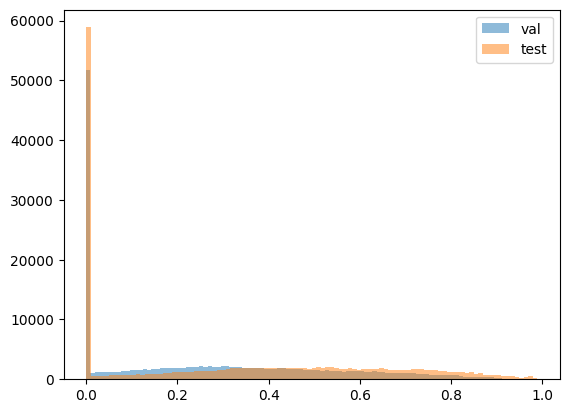

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test",
    compute_rmse: bool = True,
    collect_preds: bool = False
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:
      - compute_rmse: if True, accumulates MSE and returns RMSE
      - collect_preds: if True, gathers every window's prediction into a flat array

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None

    You can call:
      rmse, _     = evaluate_model(model, loader, device, split_name, True, False)
      _, preds    = evaluate_model(model, loader, device, split_name, False, True)
      rmse, preds = evaluate_model(model, loader, device, split_name, True, True)
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats if requested
            if compute_rmse:
                total_sq_error += (pred - y).pow(2).sum().item()
                total_windows  += y.numel()

            # collect raw preds if requested
            if collect_preds:
                all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    if compute_rmse:
        rmse = math.sqrt(total_sq_error / total_windows)
        print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    if collect_preds:
        preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [9]:
val_rmse, _     = evaluate_model(model_best, val_loader, device, split_name="Validation")
test_rmse, _     = evaluate_model(model_best, test_loader, device, split_name="Test")

_, preds = evaluate_model(model_best, test_loader, device,
                          split_name="Test",
                          compute_rmse=False, collect_preds=True)

preds.shape

Validation:   0%|          | 0/359 [00:00<?, ?day/s]


Validation RMSE over 183004 windows = 0.22071


Test:   0%|          | 0/373 [00:00<?, ?day/s]


Test RMSE over 190594 windows = 0.28002


Test:   0%|          | 0/373 [00:00<?, ?day/s]

(190594,)

In [10]:
def add_pred_actions(df: pd.DataFrame, preds: np.ndarray) -> pd.DataFrame:
    """
    1) Stamp preds on the exact minute-bars your model saw.
    2) Take only those rows (the “test split”) and
       generate trade actions on them.
    3) Return the smaller DF.
    """
    # 0) copy & init
    df = df.copy()
    df["pred_signal"] = np.nan

    # 1) build valid_idx exactly as before
    valid_ts = []
    days = sorted(df.index.normalize().unique())
    # replay the test-day logic via day_id_te:
    test_global_ids = np.unique(day_id_te)
    for gid in test_global_ids:
        day = days[int(gid)]
        day_df = df[df.index.normalize() == day].sort_index()

        # drop first LOOK_BACK bars, then mask times >= regular_start_pred
        ends = day_df.index[look_back:]
        mask = ends.time >= regular_start_pred
        valid_ts.append(ends[mask])

    valid_idx = pd.DatetimeIndex(np.concatenate([ts.values for ts in valid_ts]))

    if len(valid_idx) != len(preds):
        raise ValueError(f"{len(valid_idx)} slots vs {len(preds)} preds")

    df.loc[valid_idx, "pred_signal"] = preds

    # 2) slice to only test-rows
    df_test = df.loc[valid_idx]

    # 3) generate trade actions per test-day only
    outs = []
    for _, day_df in df_test.groupby(df_test.index.normalize(), sort=False):
        outs.append(
            trades.generate_trade_actions(
                df                   = day_df,
                col_signal           = "pred_signal",
                col_action           = "pred_action",
                buy_threshold        = pred_threshold,
                trailing_stop_thresh = trailing_stop_thresh,
                regular_start        = regular_start
            )
        )

    df_out = pd.concat(outs).sort_index()
    df_out.to_csv(path_csv_save)
    return df_out


In [11]:
df_with_preds = add_pred_actions(
    df, preds
)

df_with_preds

open     high     low   close     volume       r_1  \
2023-12-04 12:30:00  130.85  130.860  130.79  130.79       25.0 -0.000611   
2023-12-04 12:31:00  130.85  130.850  130.76  130.76      448.0 -0.000229   
2023-12-04 12:32:00  130.84  130.850  130.79  130.79      104.0  0.000229   
2023-12-04 12:33:00  130.86  130.880  130.86  130.88      876.0  0.000688   
2023-12-04 12:34:00  130.90  130.930  130.85  130.92      430.0  0.000306   
...                     ...      ...     ...     ...        ...       ...   
2025-06-17 20:56:00  176.09  176.160  176.01  176.05   126589.0 -0.000284   
2025-06-17 20:57:00  176.05  176.080  175.89  175.93   125176.0 -0.000682   
2025-06-17 20:58:00  175.93  175.975  175.86  175.89   200235.0 -0.000227   
2025-06-17 20:59:00  175.90  175.970  175.80  175.93   393414.0  0.000227   
2025-06-17 21:00:00  175.93  176.040  175.80  175.95  5670184.0  0.000114   

                          r_5      r_15    vol_15  volume_spike  vwap_dev  \
2023-12-04 12:30:00  0.000459  0.000688  0.000477      0.118972  0.948292   
2023-12-04 12:31:00 -0.000917  0.001148  0.000440      2.255791  0.947845   
2023-12-04 12:32:00 -0.000688  0.000765  0.000417      0.515021  0.948292   
2023-12-04 12:33:00 -0.000382  0.001682  0.000440      3.417425  0.949632   
2023-12-04 12:34:00  0.000382  0.001988  0.000441      1.513729  0.950228   
...                       ...       ...       ...           ...       ...   
2025-06-17 20:56:00 -0.000681 -0.001297  0.000443      1.610125  1.217786   
2025-06-17 20:57:00 -0.000398 -0.001761  0.000469      1.478464  1.216271   
2025-06-17 20:58:00 -0.001023 -0.002016  0.000468      2.096227  1.215761   
2025-06-17 20:59:00 -0.001136 -0.002073  0.000464      3.295458  1.216254   
2025-06-17 21:00:00 -0.000852 -0.002469  0.000435     11.461178  1.216344   

                        rsi_14       bid       ask  signal_smooth  \
2023-12-04 12:30:00  66.071429  130.7508  130.8292            0.0   
2023-12-04 12:31:00  56.862745  130.7208  130.7992            0.0   
2023-12-04 12:32:00  62.745098  130.7508  130.8292            0.0   
2023-12-04 12:33:00  68.333333  130.8407  130.9193            0.0   
2023-12-04 12:34:00  67.241379  130.8807  130.9593            0.0   
...                        ...       ...       ...            ...   
2025-06-17 20:56:00  39.325843  175.9972  176.1028            0.0   
2025-06-17 20:57:00  34.328358  175.8772  175.9828            0.0   
2025-06-17 20:58:00  29.648241  175.8372  175.9428            0.0   
2025-06-17 20:59:00  25.925926  175.8772  175.9828            0.0   
2025-06-17 21:00:00  27.748691  175.8972  176.0028            0.0   

                     pred_signal  pred_action  
2023-12-04 12:30:00     0.245164            0  
2023-12-04 12:31:00     0.242989            0  
2023-12-04 12:32:00     0.239368            0  
2023-12-04 12:33:00     0.240065            0  
2023-12-04 12:34:00     0.236034            0  
...                          ...          ...  
2025-06-17 20:56:00     0.222006            0  
2025-06-17 20:57:00     0.214236            0  
2025-06-17 20:58:00     0.207078            0  
2025-06-17 20:59:00     0.201770            0  
2025-06-17 21:00:00     0.198276           -1  

[190594 rows x 17 columns]

In [12]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,              # full DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,       
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2025-04:


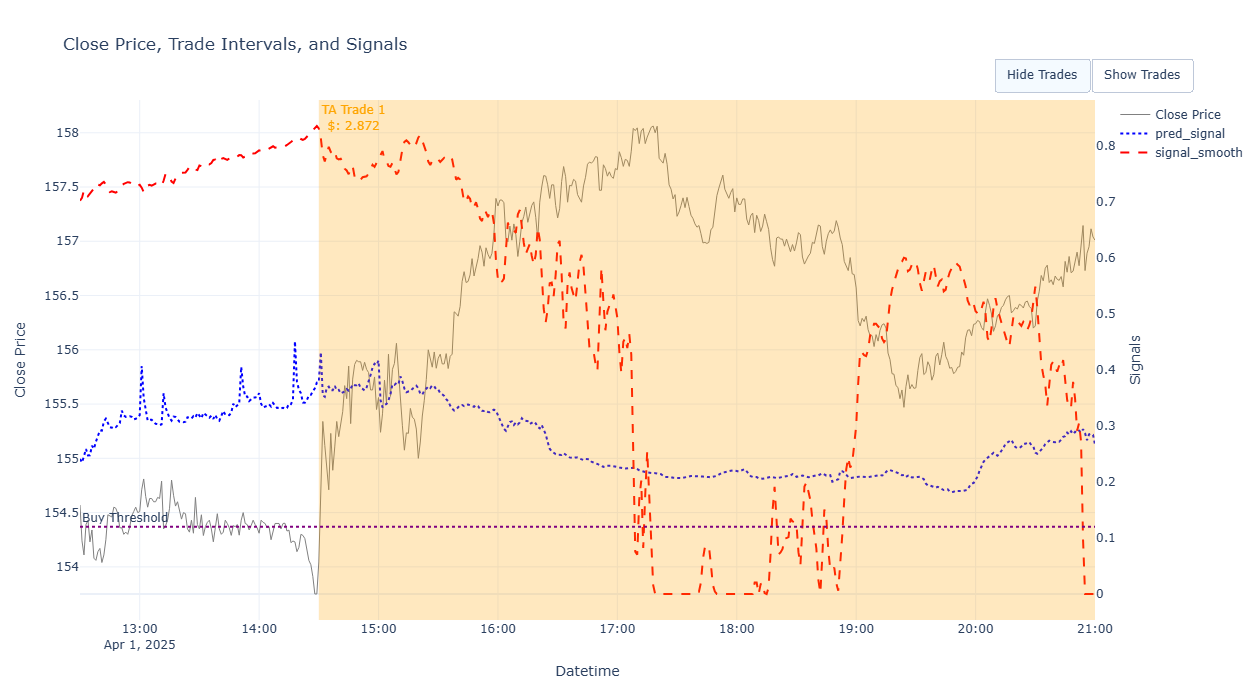


=== Performance for 2025-04-01 00:00:00 ===
Strategy Return ($): 2.902
Buy & Hold Return ($): 2.902
Trades Returns ($): [2.872]


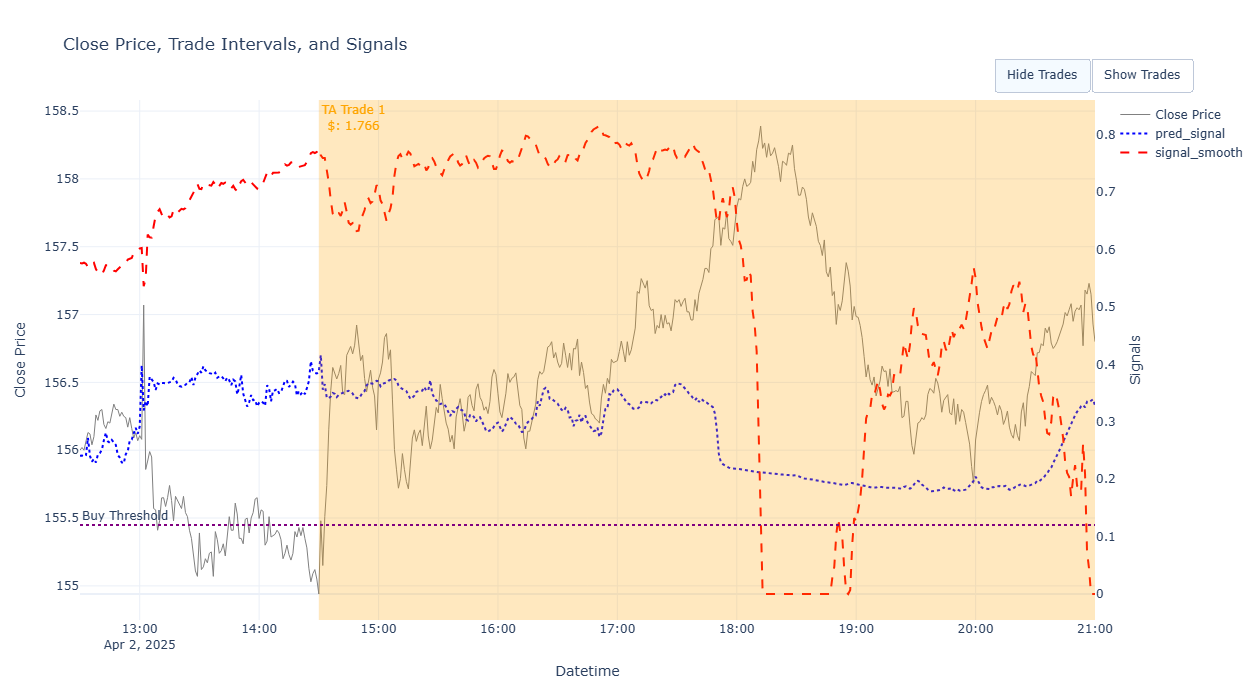


=== Performance for 2025-04-02 00:00:00 ===
Strategy Return ($): 1.896
Buy & Hold Return ($): 1.896
Trades Returns ($): [1.766]


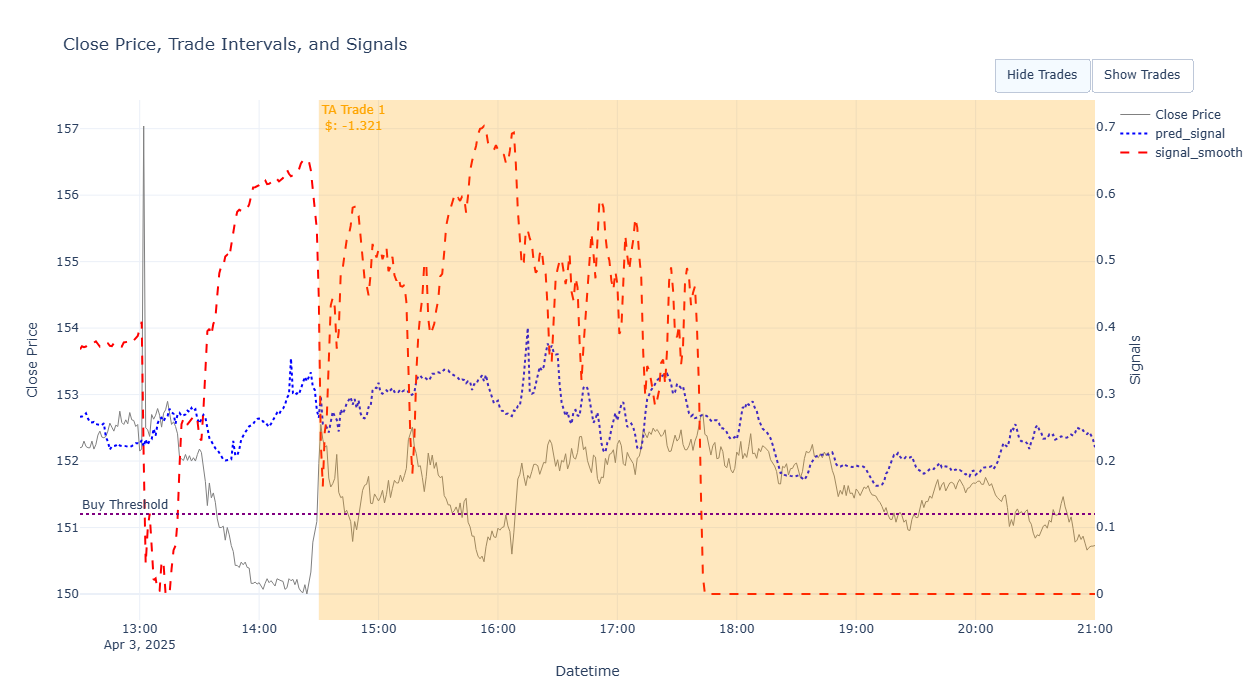


=== Performance for 2025-04-03 00:00:00 ===
Strategy Return ($): -1.331
Buy & Hold Return ($): -1.331
Trades Returns ($): [-1.321]


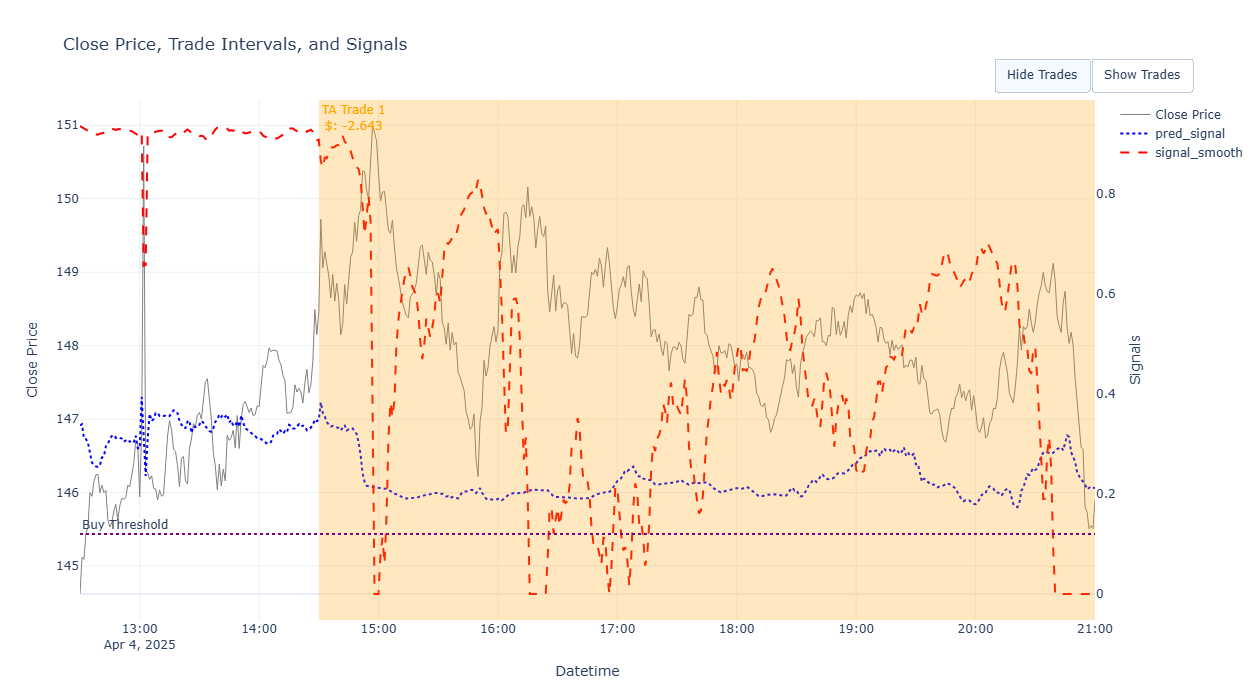


=== Performance for 2025-04-04 00:00:00 ===
Strategy Return ($): -3.043
Buy & Hold Return ($): -3.043
Trades Returns ($): [-2.643]


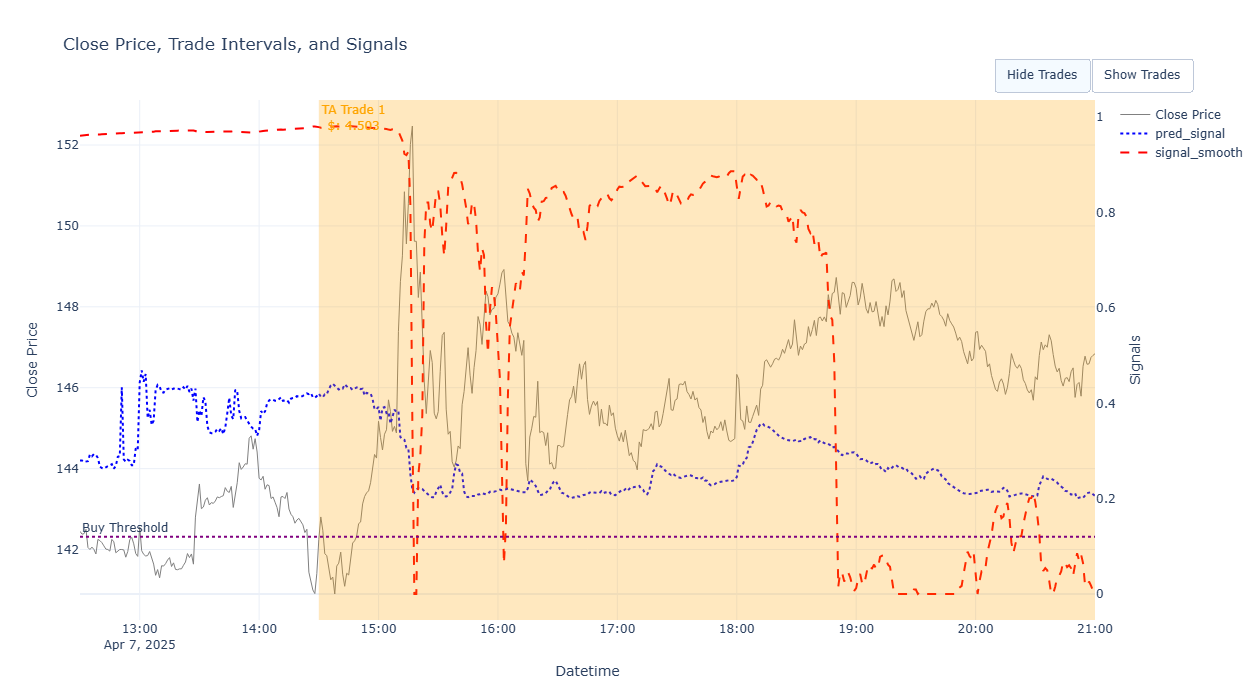


=== Performance for 2025-04-07 00:00:00 ===
Strategy Return ($): 4.463
Buy & Hold Return ($): 4.463
Trades Returns ($): [4.503]


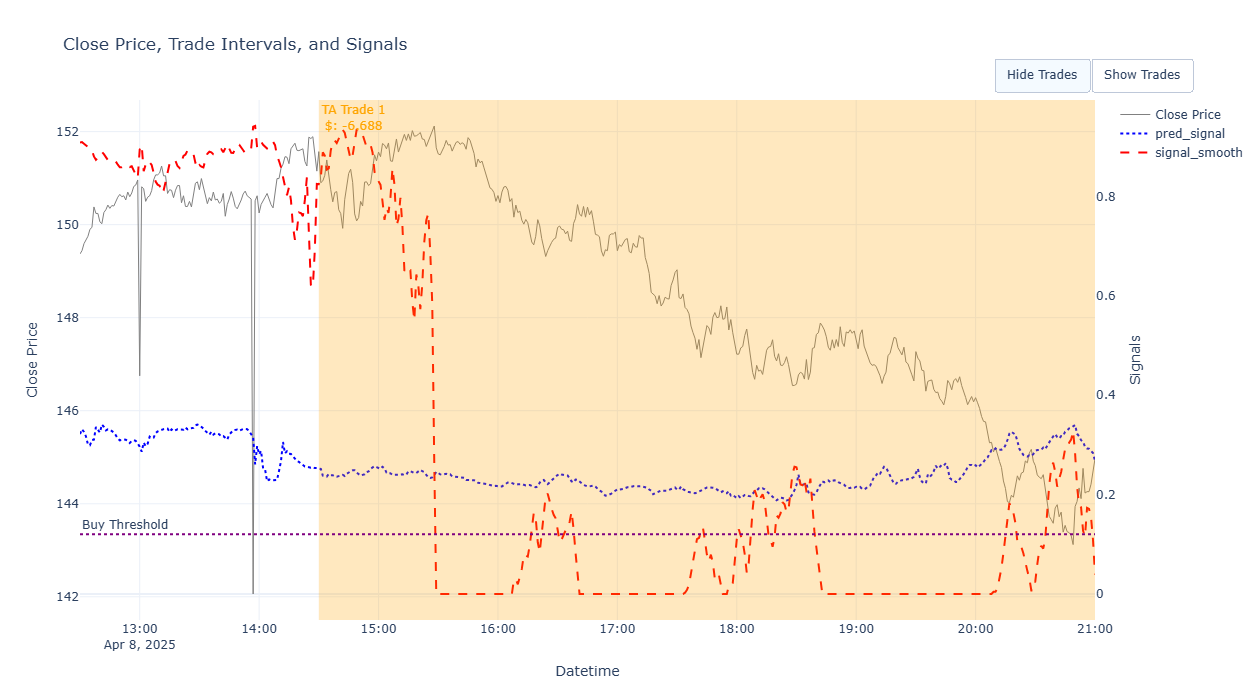


=== Performance for 2025-04-08 00:00:00 ===
Strategy Return ($): -6.978
Buy & Hold Return ($): -6.978
Trades Returns ($): [-6.688]


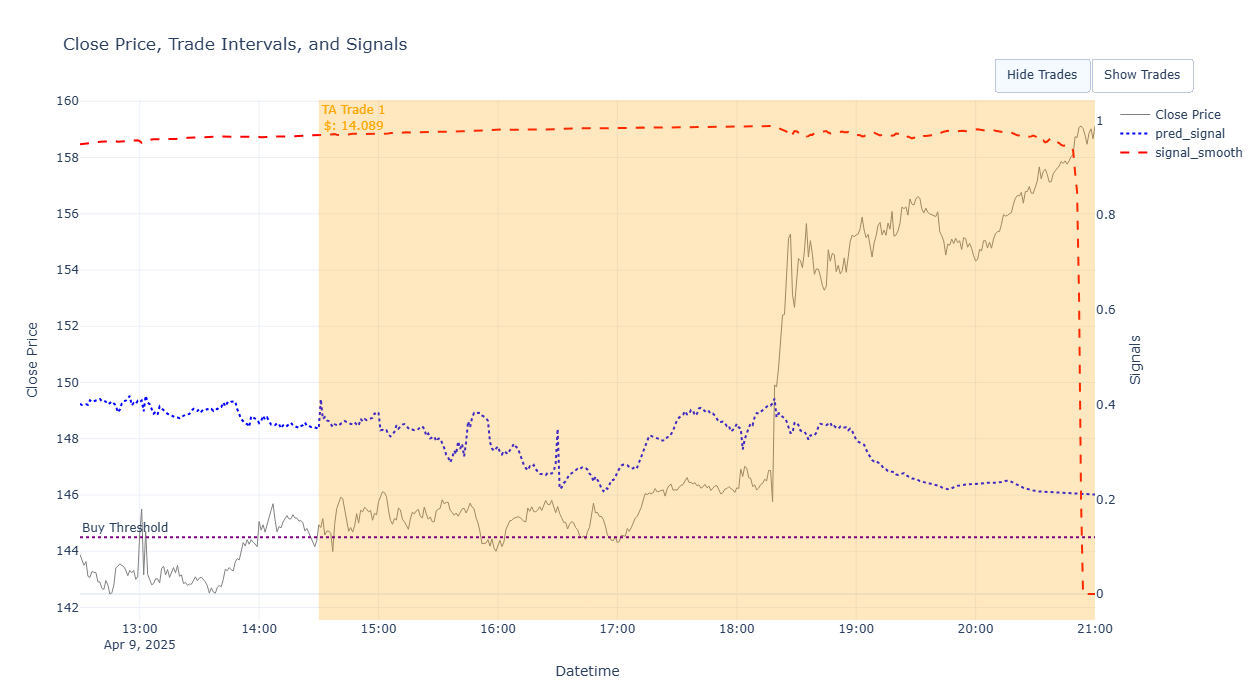


=== Performance for 2025-04-09 00:00:00 ===
Strategy Return ($): 13.639
Buy & Hold Return ($): 13.639
Trades Returns ($): [14.089]


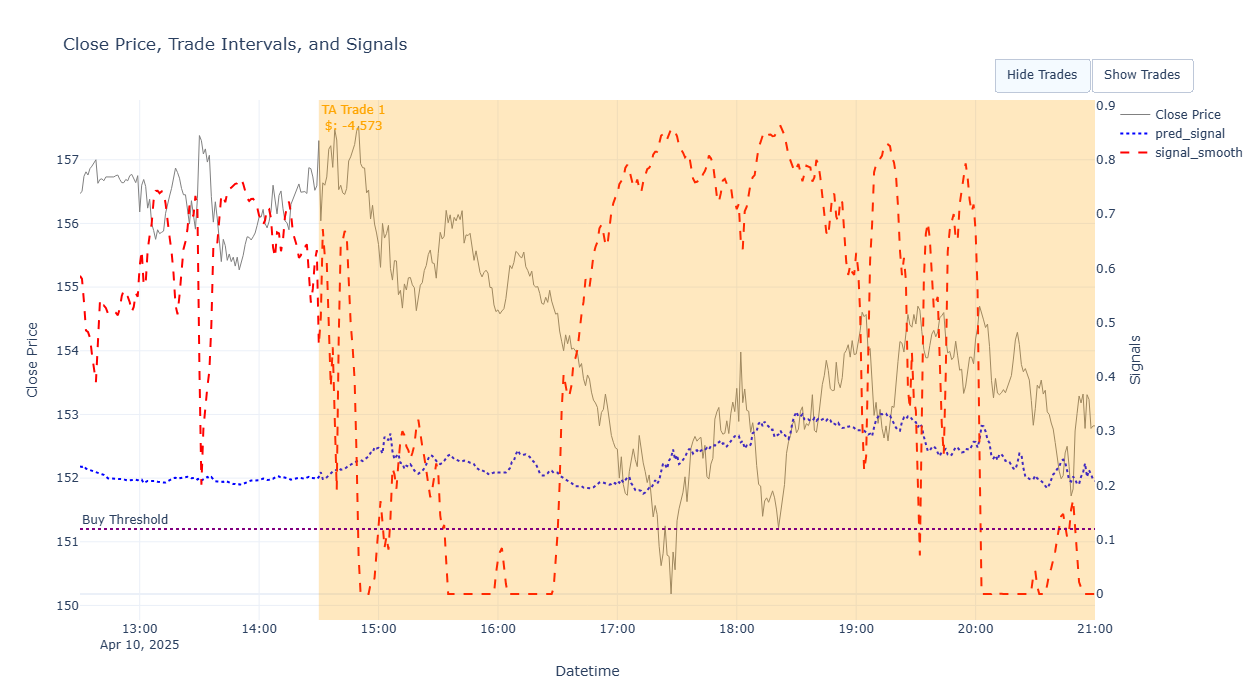


=== Performance for 2025-04-10 00:00:00 ===
Strategy Return ($): -4.573
Buy & Hold Return ($): -4.573
Trades Returns ($): [-4.573]


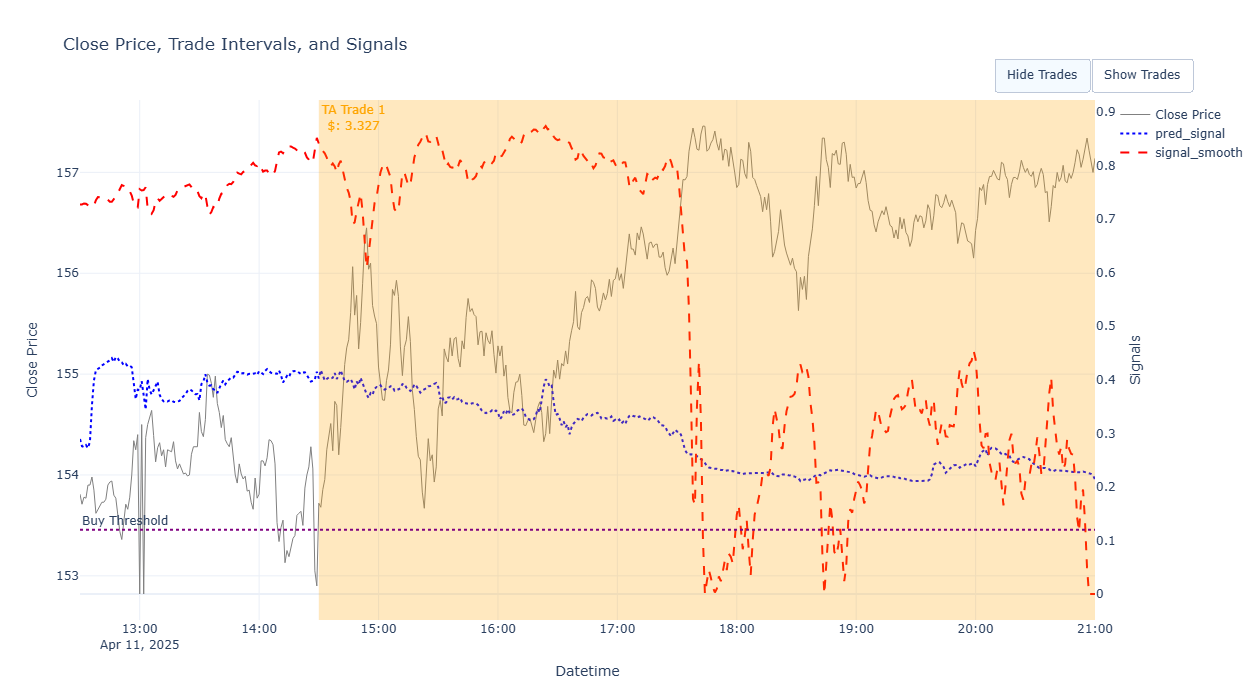


=== Performance for 2025-04-11 00:00:00 ===
Strategy Return ($): 3.187
Buy & Hold Return ($): 3.187
Trades Returns ($): [3.327]


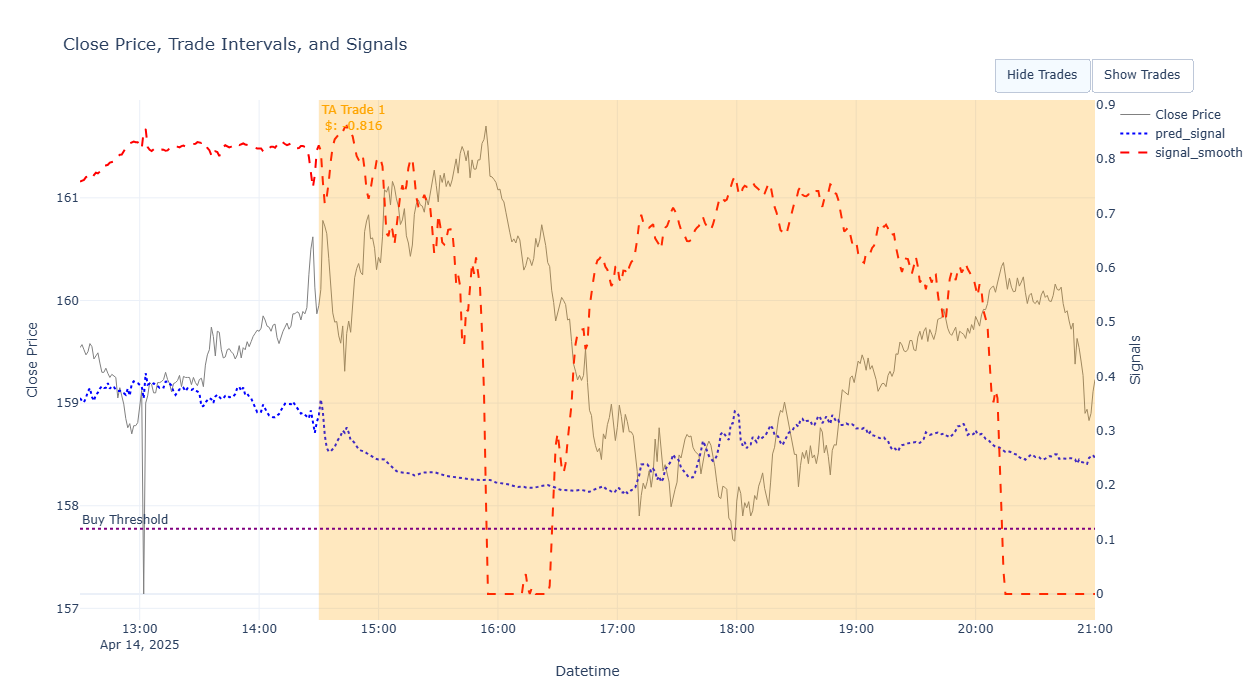


=== Performance for 2025-04-14 00:00:00 ===
Strategy Return ($): -0.936
Buy & Hold Return ($): -0.936
Trades Returns ($): [-0.816]


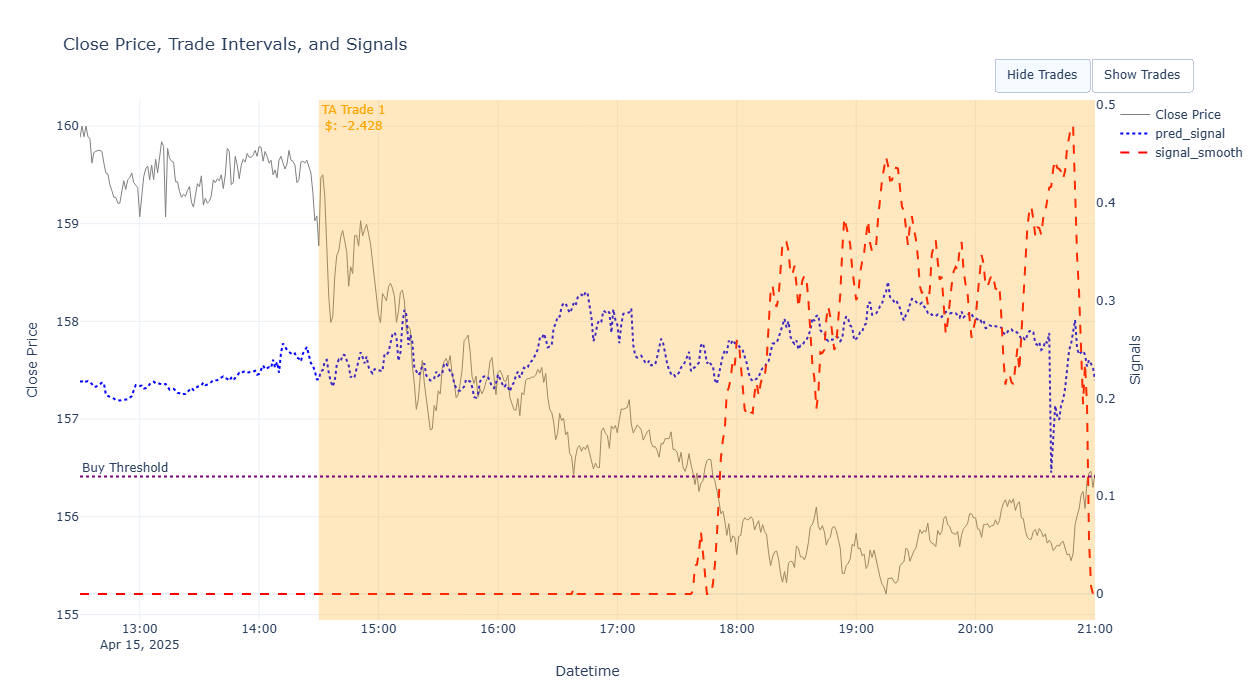


=== Performance for 2025-04-15 00:00:00 ===
Strategy Return ($): -2.568
Buy & Hold Return ($): -2.568
Trades Returns ($): [-2.428]


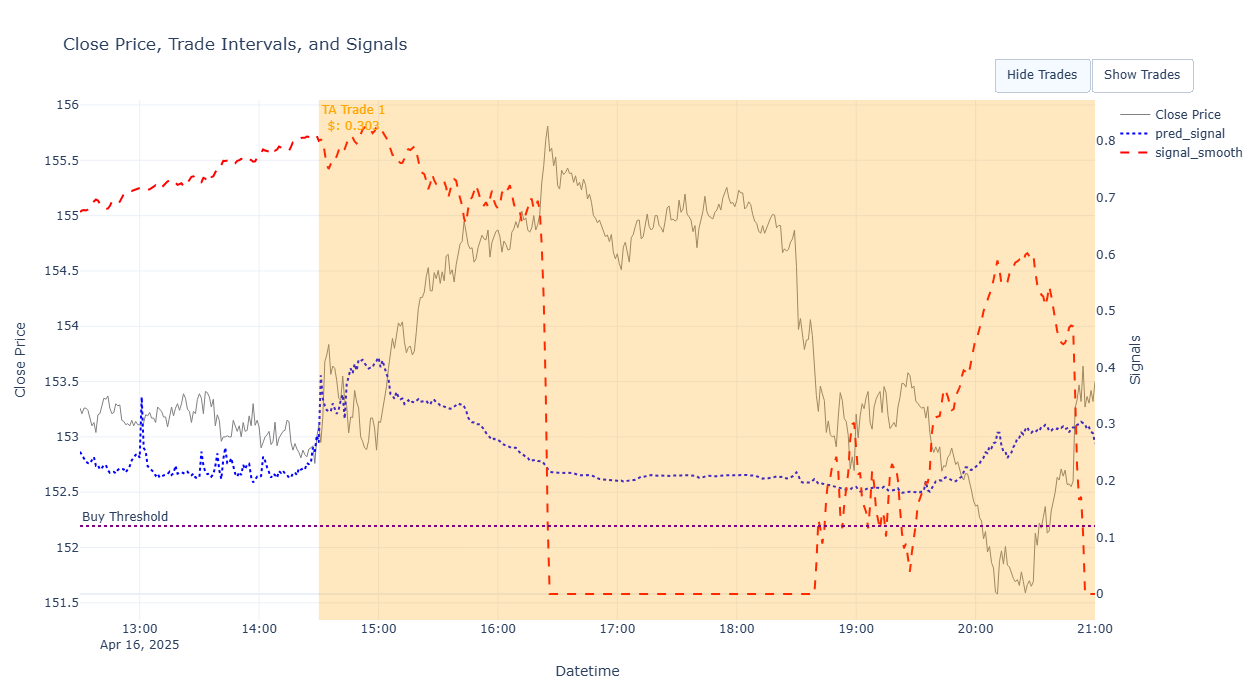


=== Performance for 2025-04-16 00:00:00 ===
Strategy Return ($): 0.123
Buy & Hold Return ($): 0.123
Trades Returns ($): [0.303]


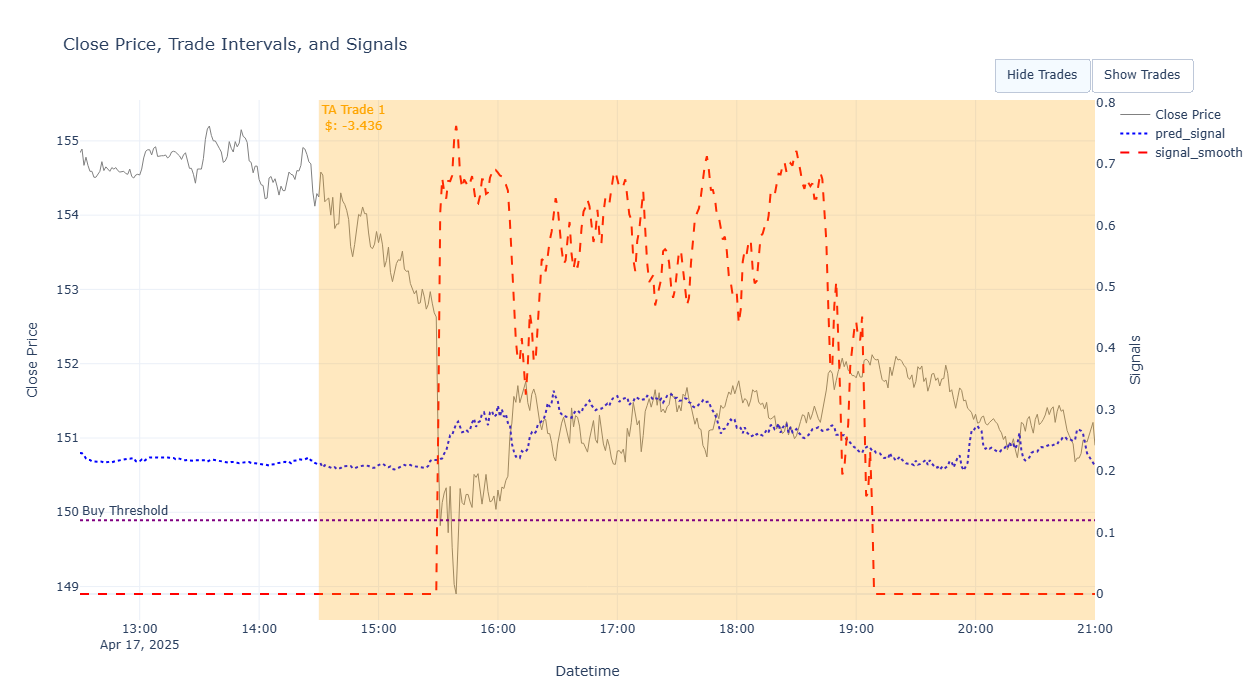


=== Performance for 2025-04-17 00:00:00 ===
Strategy Return ($): -3.127
Buy & Hold Return ($): -3.127
Trades Returns ($): [-3.436]


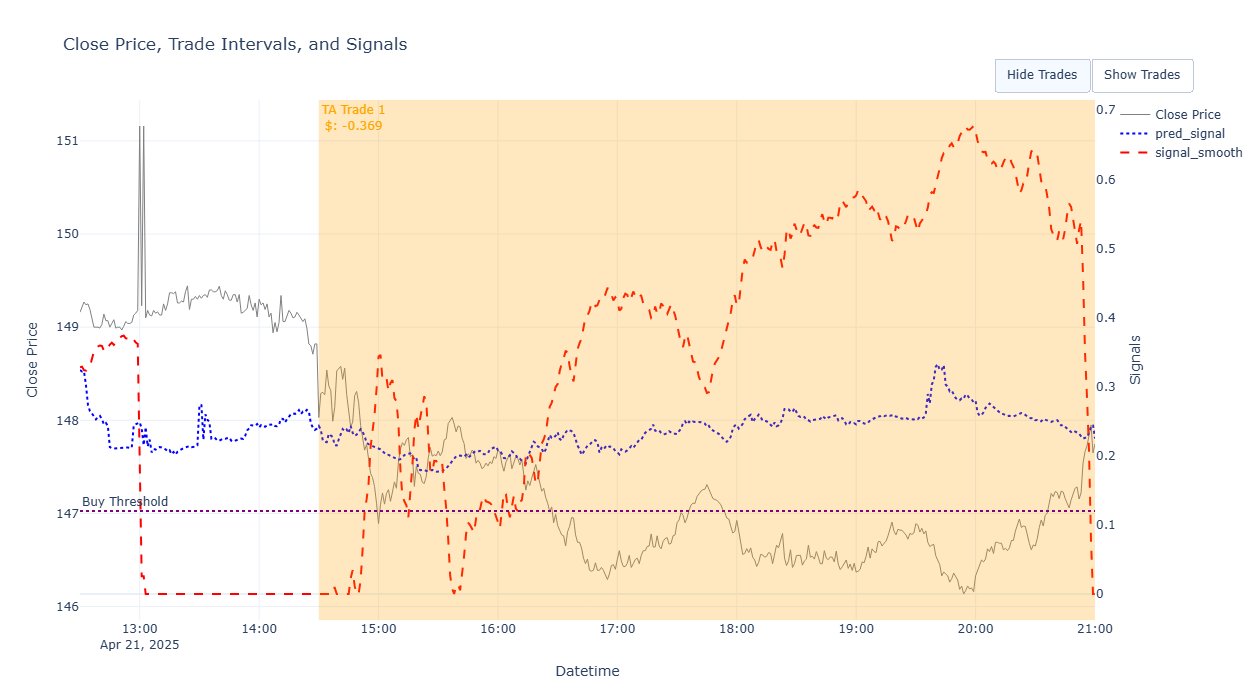


=== Performance for 2025-04-21 00:00:00 ===
Strategy Return ($): -0.469
Buy & Hold Return ($): -0.469
Trades Returns ($): [-0.369]


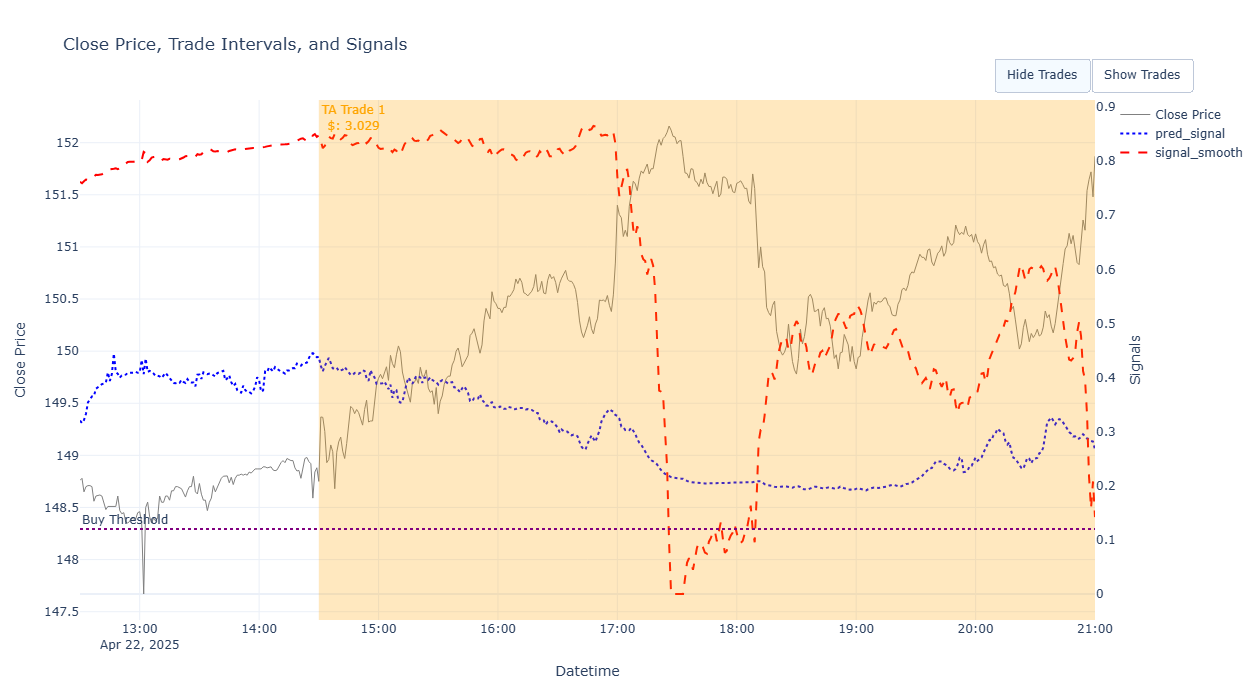


=== Performance for 2025-04-22 00:00:00 ===
Strategy Return ($): 2.639
Buy & Hold Return ($): 2.639
Trades Returns ($): [3.029]


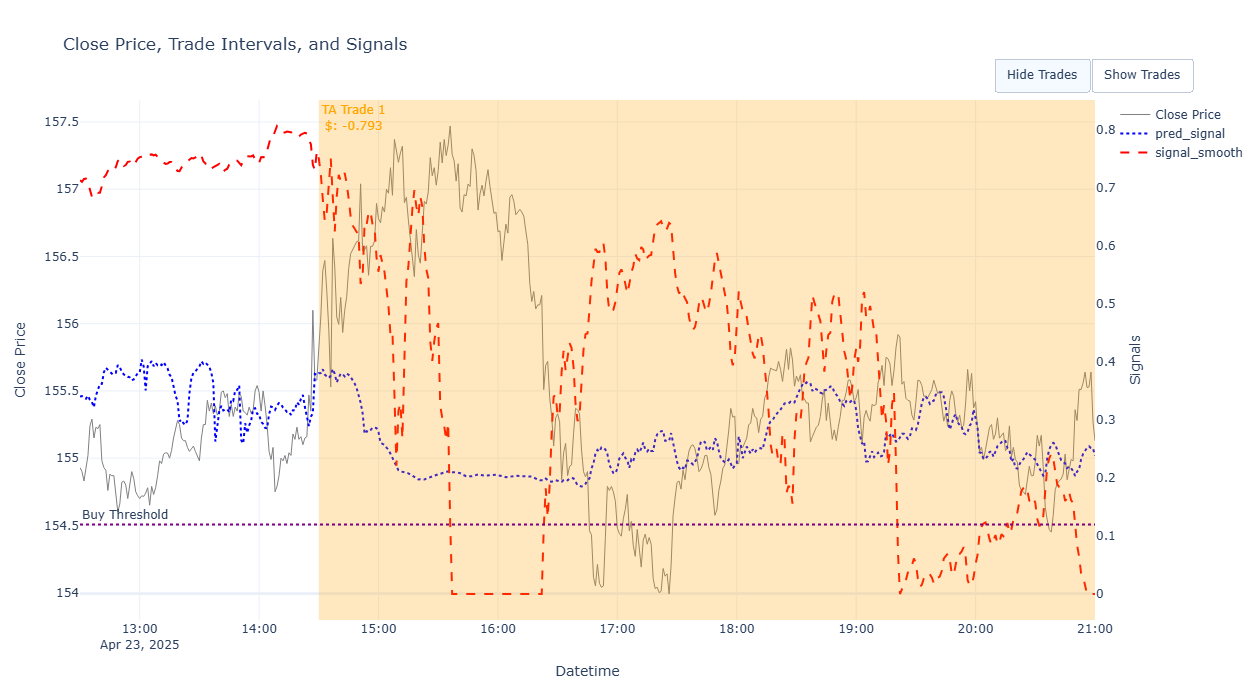


=== Performance for 2025-04-23 00:00:00 ===
Strategy Return ($): -0.653
Buy & Hold Return ($): -0.653
Trades Returns ($): [-0.793]


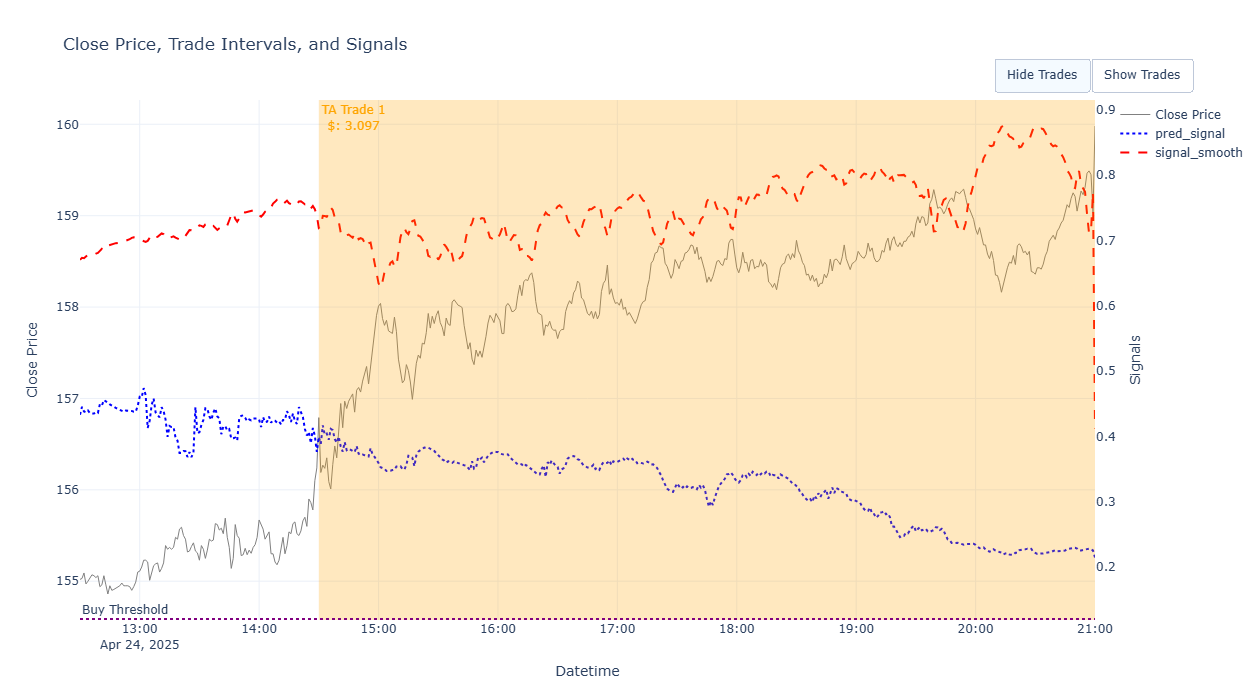


=== Performance for 2025-04-24 00:00:00 ===
Strategy Return ($): 2.15
Buy & Hold Return ($): 2.15
Trades Returns ($): [3.097]


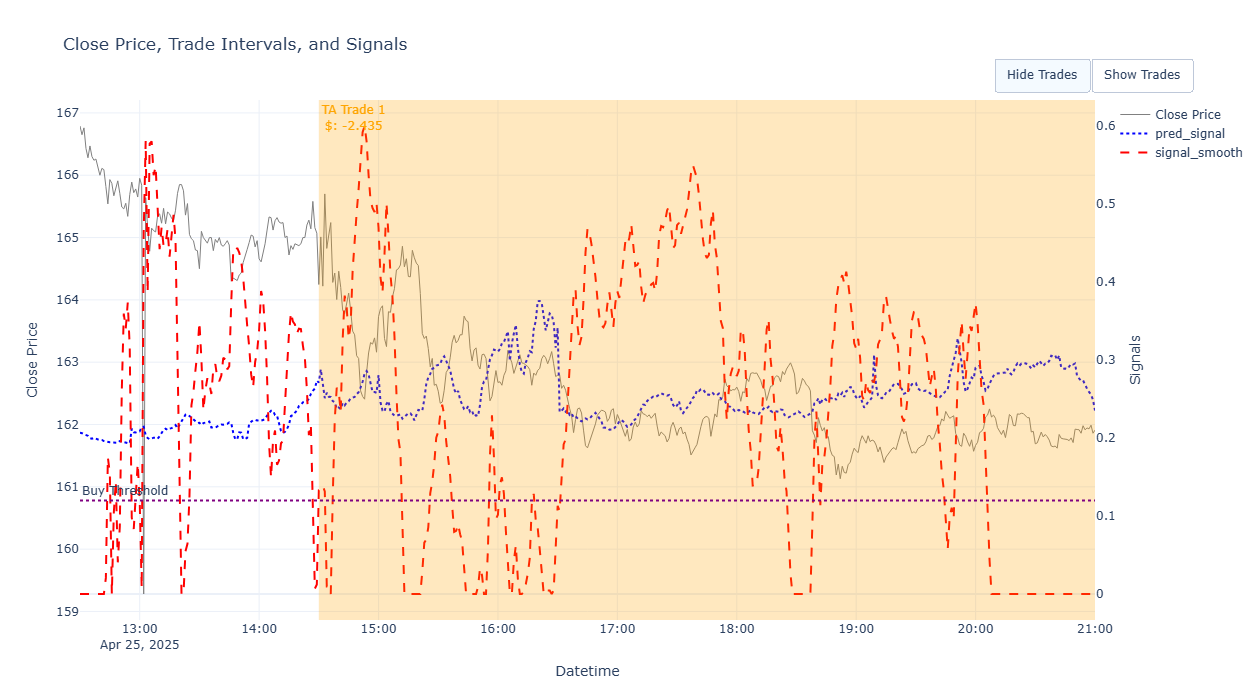


=== Performance for 2025-04-25 00:00:00 ===
Strategy Return ($): -2.485
Buy & Hold Return ($): -2.485
Trades Returns ($): [-2.435]


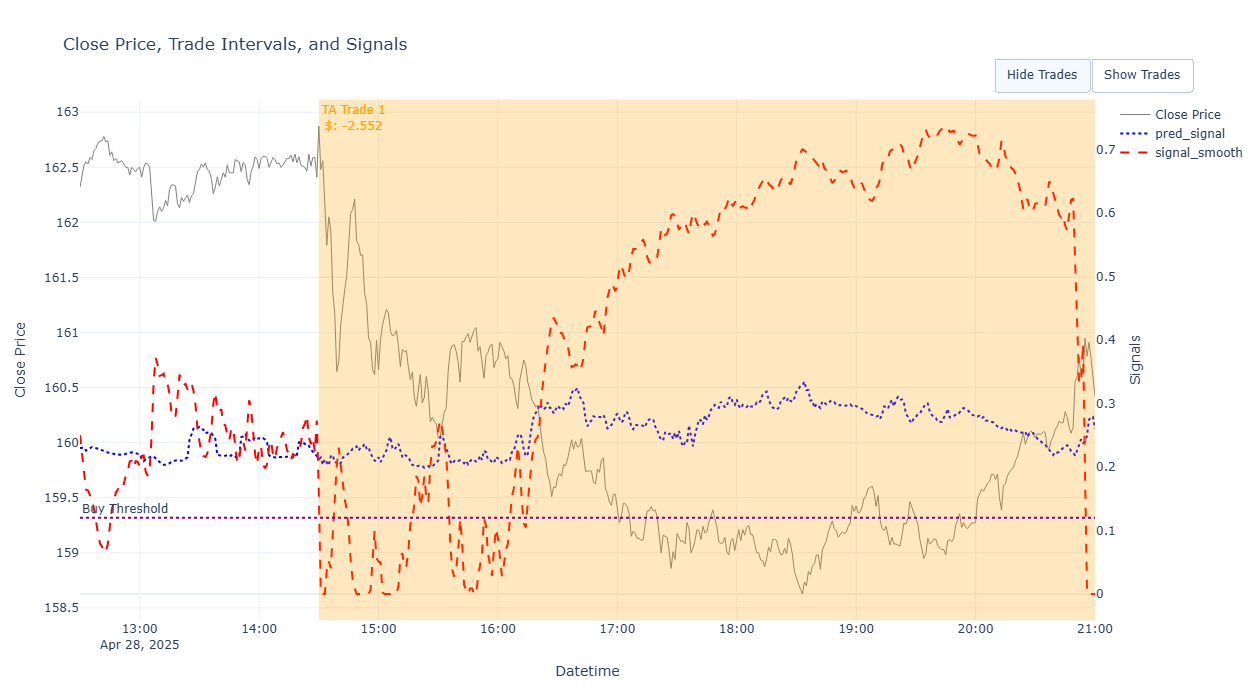


=== Performance for 2025-04-28 00:00:00 ===
Strategy Return ($): -2.362
Buy & Hold Return ($): -2.362
Trades Returns ($): [-2.552]


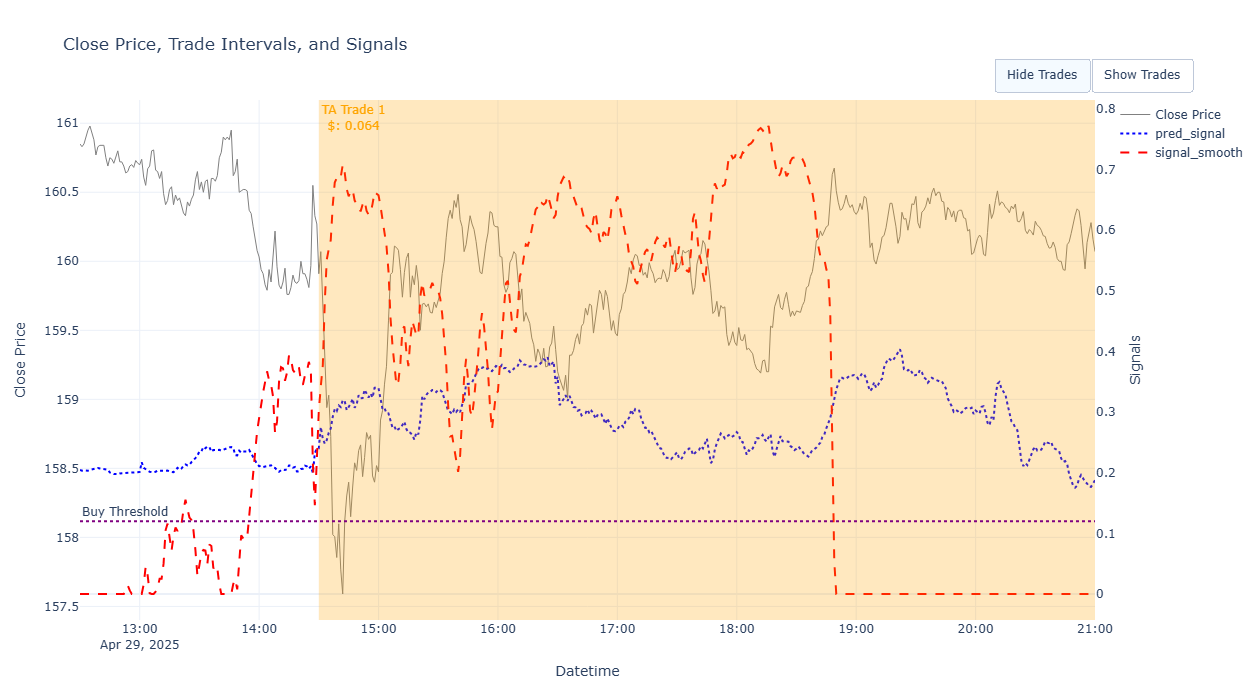


=== Performance for 2025-04-29 00:00:00 ===
Strategy Return ($): 0.154
Buy & Hold Return ($): 0.154
Trades Returns ($): [0.064]


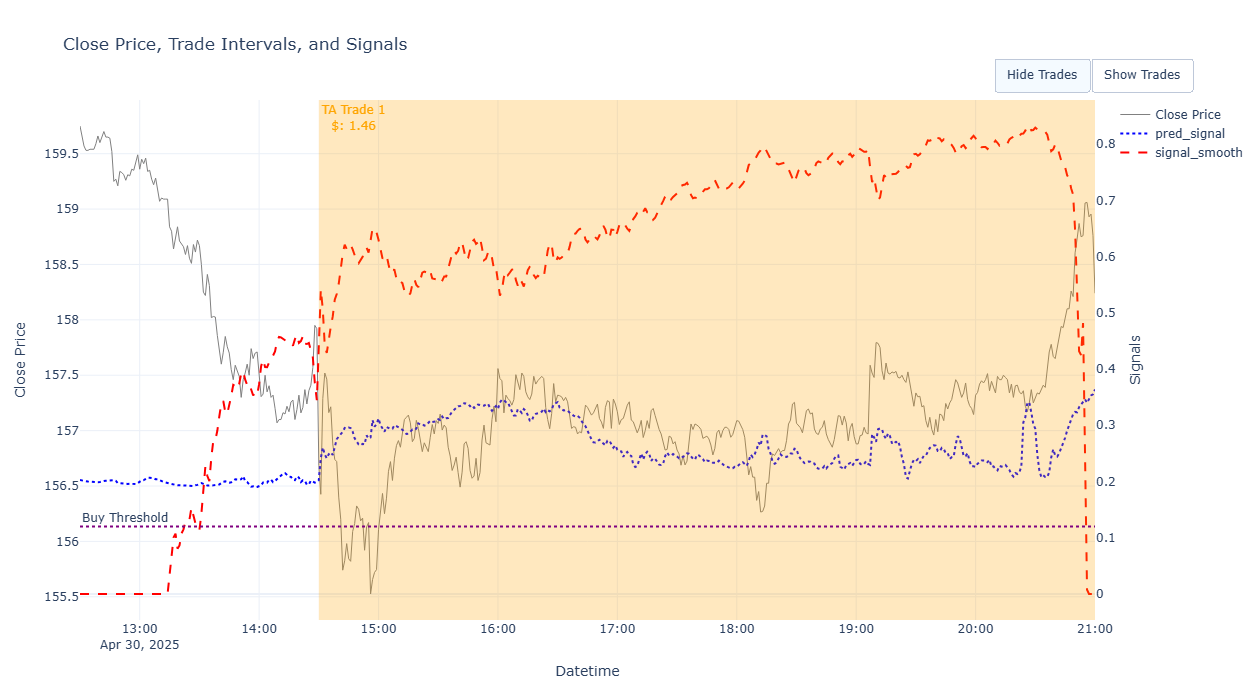


=== Performance for 2025-04-30 00:00:00 ===
Strategy Return ($): 1.98
Buy & Hold Return ($): 1.98
Trades Returns ($): [1.46]

=== Overall Summary (2025-04-01 → 2025-04-30) ===
Start date price: 2025-04-01 = 154.0912
  End date price:  2025-04-30 = 158.1925
One-time buy&hold gain: 4.101

{'Buy & Hold – each day ($)': 4.608,
 'Strategy Return ($)': 4.608,
 'Trades Returns ($)': '21 trades'}

=== Overall Summary (2023-12-04 → 2025-06-17) ===
Start date price: 2023-12-04 = 129.4938
  End date price:  2025-06-17 = 175.8972
One-time buy&hold gain: 46.403

{'Buy & Hold – each day ($)': -50.193,
 'Strategy Return ($)': -50.34,
 'Trades Returns ($)': '383 trades'}


In [13]:
year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_man,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
